In [1]:

# takes packages files from the specified folder
import os
import sys
sys.path.insert(0, os.path.join(os.getcwd(), '..\\..'))
from squlearn.feature_map import ChebPQC, YZ_CX_FeatureMap
from squlearn.kernel.matrix import FidelityKernel
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.primitives import Sampler, Estimator

In [2]:
import numpy as np
statevec = Aer.get_backend('statevector_simulator')
QI_statevec = QuantumInstance(statevec)
# set up quantum kernel and qgpr
num_qubits = 4
fmap = ChebPQC(
    num_qubits,num_features=1, num_layers=2)
np.random.seed(0)
param = np.random.rand(fmap.num_parameters)
q_kernel = FidelityKernel(
    feature_map=fmap,quantum_instance=statevec)
q_kernel.assign_parameters(param)

In [3]:
# Generate training data.
def func(x):
    return np.sin(3*x)*x*x

noise_variance = 0.05
X_test = np.linspace(-1,1,100)
Y_test = func(X_test)
X_train = np.linspace(-1,1,15) 
Y_train = func(X_train) + np.random.normal(scale=noise_variance, size=len(X_train))


In [4]:
from src.squlearn.kernel.ml import QGPR
qgpr = QGPR(q_kernel, sigma=0.01, regularize='off')

In [5]:
qgpr.fit(X_train.reshape(-1,1),Y_train)

QGPR(quantum_kernel=<squlearn.kernel.matrix.fidelity_kernel.FidelityKernel object at 0x0000020C2D498520>,
     sigma=0.01)

In [6]:
qgpr.get_params()

{'quantum_kernel': <squlearn.kernel.matrix.fidelity_kernel.FidelityKernel at 0x20c2d498520>,
 'sigma': 0.01,
 'normalize_y': False}

In [7]:
sk_mean, sk_std = qgpr.predict(X_test.reshape(-1,1),return_std=True)

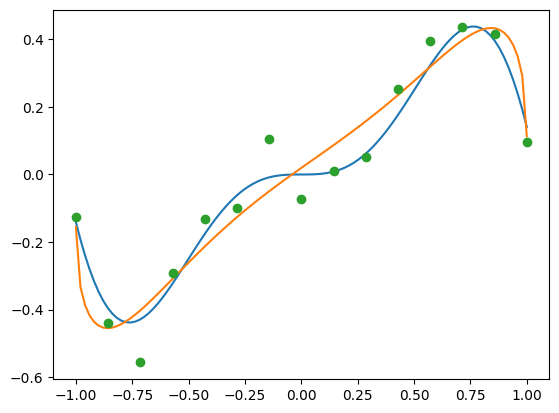

In [8]:
import matplotlib.pyplot as plt
plt.plot(X_test,Y_test,label='true')
plt.plot(X_test,sk_mean,label='sklearn')
plt.plot(X_train,Y_train,'o',label='train')

In [10]:
from src.squlearn.kernel.ml.kernel_util import kernel_wrapper
from sklearn.gaussian_process import GaussianProcessRegressor

wrapped_kernel = kernel_wrapper(q_kernel)
sk_gp = GaussianProcessRegressor(kernel=wrapped_kernel, alpha=0.1)

In [11]:
sk_gp.fit(X_train.reshape(-1,1),Y_train)
mean = sk_gp.predict(X_test.reshape(-1,1))

In [12]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel

matern = Matern(length_scale=1.0, nu=1.5)
test_kernel = matern + wrapped_kernel + RBF() + ConstantKernel()
sk_kridge = KernelRidge(kernel=test_kernel, alpha=0.1)
sk_svr = SVR(kernel=wrapped_kernel)

In [13]:
sk_kridge.get_params()

{'alpha': 0.1,
 'coef0': 1,
 'degree': 3,
 'gamma': None,
 'kernel__k1': Matern(length_scale=1, nu=1.5) + CustomKernel() + RBF(length_scale=1),
 'kernel__k2': 1**2,
 'kernel__k1__k1': Matern(length_scale=1, nu=1.5) + CustomKernel(),
 'kernel__k1__k2': RBF(length_scale=1),
 'kernel__k1__k1__k1': Matern(length_scale=1, nu=1.5),
 'kernel__k1__k1__k2': CustomKernel(),
 'kernel__k1__k1__k1__length_scale': 1.0,
 'kernel__k1__k1__k1__length_scale_bounds': (1e-05, 100000.0),
 'kernel__k1__k1__k1__nu': 1.5,
 'kernel__k1__k1__k2__kernel_matrix': <squlearn.kernel.matrix.fidelity_kernel.FidelityKernel at 0x20c2d498520>,
 'kernel__k1__k2__length_scale': 1.0,
 'kernel__k1__k2__length_scale_bounds': (1e-05, 100000.0),
 'kernel__k2__constant_value': 1.0,
 'kernel__k2__constant_value_bounds': (1e-05, 100000.0),
 'kernel': Matern(length_scale=1, nu=1.5) + CustomKernel() + RBF(length_scale=1) + 1**2,
 'kernel_params': None}

In [14]:
sk_kridge.fit(X_train.reshape(-1,1),Y_train)
sk_svr.fit(X_train.reshape(-1,1),Y_train)
mean_krr = sk_kridge.predict(X_test.reshape(-1,1))
mean_svr = sk_svr.predict(X_test.reshape(-1,1))

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sk_kridge,X_train.reshape(-1,1),Y_train,cv=5)

array([-0.26670402, -1.32730158, -1.24968269,  0.72622319, -0.42798088])